<img src="images/charizard.png" alt="Expert" width="200">

# Expert level

<img src="http://www.animatedgif.net/underconstruction/5consbar2_e0.gif">
<div style="border: 5px solid red; padding: 20px;"><p>I'm currently writing the exercise for this level. It is not done yet, but it will be before the workshop begins!</p></div>
<img src="http://www.animatedgif.net/underconstruction/5consbar2_e0.gif">

Welcome to the expert level!
For this level, I'm assuming you are somewhat familiar with the Python programming language, for example by completing the ['adept'](adapt.ipynb) level, or having done some other projects in Python.
Alternatively, if you have enough experience in other programming languages, you can follow along.
If some aspect of the Python programming language is unclear, I found Jake VanderPlas' ["A whirlwind tour of Python"](http://www.oreilly.com/programming/free/files/a-whirlwind-tour-of-python.pdf) a great reference to quickly look things up.

During the next half hour, we are going to construct a basic pipeline that begins with some raw MEG data and performs a minimum-norm estimate (MNE) of the cortical sources.

## The experiment

I have prepared a bit of MEG data for you. It was recorded while a brave volunteer was in the scanner, listening to auditory beeps and looking at visual checkerboards. The volunteer was staring at a "fixation cross" in the center of a screen in front of him/her. From time to time, beeps sounded from either the left or the right side of his/her head. At other times, a checkerboard would be displayed either to the left or right side of to the cross. The volunteer was instructed to keep his/her eyes fixed on the cross and not directly look at the checkerboards. This way, the checkerboard was presented either to the left or right visual field of the volunteer.

<center>
    <img src="images/sound.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/checkerboard.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/cross.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/checkerboard.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/sound.png" width="100" style="display: inline; transform: scaleX(-1);">
</center>

By analyzing the MEG signal, we should be able to see the activity in the auditory and visual cortices.

## Some housekeeping

First order of business is to import the MNE-Python module `mne` and configure the graphics engine to send all figures to the browser.
Executing the cell below will accomplish this.

In [6]:
# Import the MNE-Python module, which contains all the data analysis routines we need
import mne
print('MNE-Python imported.')

# Configure the graphics engine
%matplotlib notebook
from mayavi import mlab  # Mayavi is used for 3D graphics
mlab.init_notebook('ipy')  # This instructs Mayavi to render in the background and send png graphics to the browser
print('From now on, all graphics will send to your browser.')

MNE-Python imported.
Notebook initialized with ipy backend.
From now on, all graphics will send to your browser.


## Overview of MNE-Python and how to view the documentation

The MNE-Python software module is subdivided in several sub-modules, all housing classes and functions related to different aspects of data analysis. Here are the sub-modules that are relevant for this exercise:

[`mne`](https://www.martinos.org/mne/stable/python_reference.html#module-mne) - Top level module, containing general purpose classes/functions as well as all sub-modules  
[`mne.io`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.io) - Functions related to loading data in different formats  
[`mne.viz`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.viz) - Functions related to data visualization  
[`mne.minimum_norm`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.minimum_norm) - Classes and functions related to performing minimum norm estimates (MNE)

Documentation of all functions and classes can be found at the [Python API reference](https://www.martinos.org/mne/stable/python_reference.html) page.
For quick access, all class/function names used in this notebook are also links to their respective documentation pages.
To use MNE-Python effectively for your own projects, you need to be able to use the documentation.
Therefore, I'm not going to spell out how to call each function, but instead want you to use the documentation to look up this information.

## Loading data

Let's dive in by loading some data and looking at the raw signal coming out of the MEG scanner.
The function to load the FIFF files that are produced by the recording software is called [`mne.io.read_raw_fif`](https://www.martinos.org/mne/stable/generated/mne.io.read_raw_fif.html). Take a look at its documentation. From the function signature we can see the function has one required argument, the name of the file to load, and several optional arguments that we can leave alone for now.

The file with the raw data is `'data/sample-raw.fif'`.
In the cell below, write the line of code to load it using the [`mne.io.read_raw_fif`](https://www.martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function and store the result in a variable called `raw`.

In [7]:
# Write your line of code here
raw = mne.io.read_raw_fif('data/sample-raw.fif')

If the code was correct, the cell below will visualize the raw data, using an interactive figure.
Click in the scrollbars or use the arrow keys to scroll through the data.

<IPython.core.display.Javascript object>


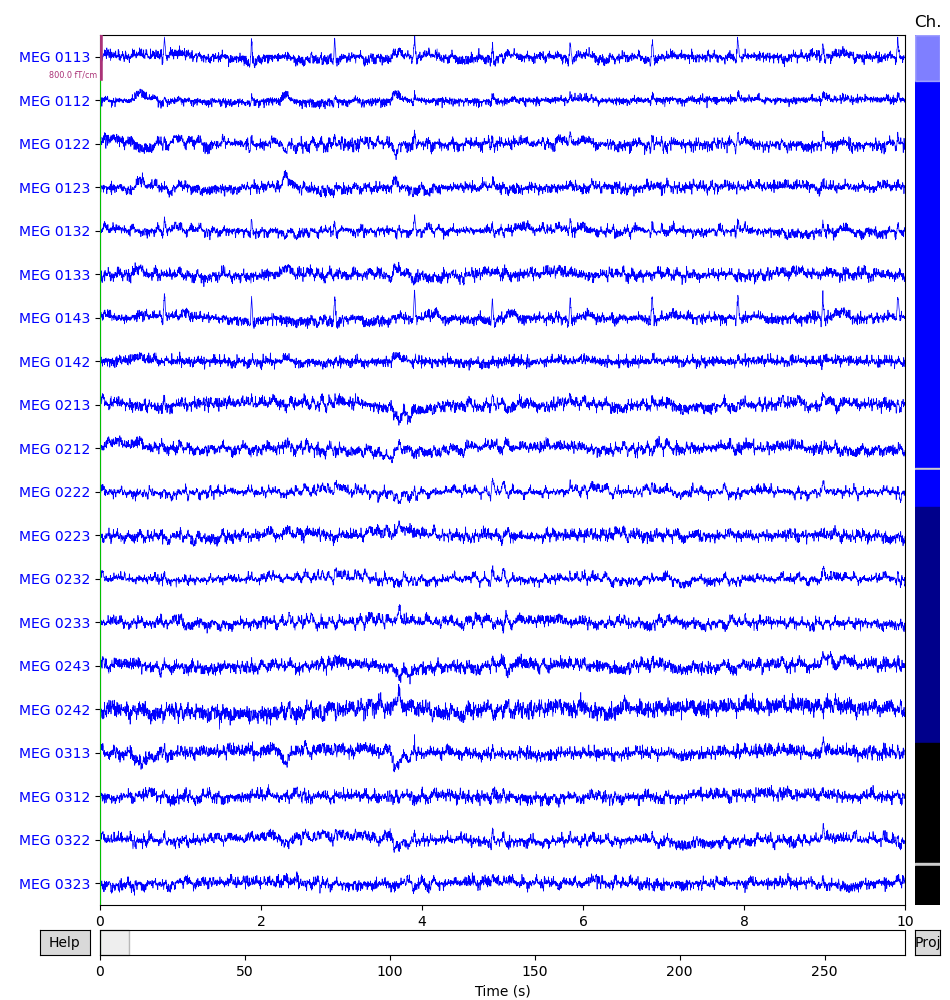

In [8]:
# Lots of MNE-Python objects have a .plot() method, and mne.Raw is no exception
raw.plot();  # Note the semicolon ; at the end, see the text below to find out why

<div style="border: 3px solid #aaccff; margin: 10px 100px; padding: 10px">
    <b>What's with the semicolon ; ?</b>
    
The Jupyter notebook you are working in right now displays the result of the last statement in a code cell. The plotting functions return a figure object. Therefore, if the last statement of a cell is a call to a plotting function, the figure is displayed twice: one when the function is called, and once more when the figure object is displayed by the Jupyter notebook. By ending a line with a semicolon `;`, we suppress the result by starting a new empty statement.
</div>

Browsing through the channels, you will notice there are several channel types:

 * <span style="color: #0000ff">204 MEG gradiometers (102 pairs of two)</span>
 * <span style="color: #00008b">102 MEG magnetometers</span>
 * 60 EEG sensors
 * 9 STIM channels
 * 1 EOG sensor
 
All these channels record different information about the volunteer and the environment.

Staring at the raw data is not very helpful.
The brain is constantly doing all kinds of things, so there are a lot overlapping signals in the data.

For this exercise, we are interested only in the signals that are related to processing the visual and auditory stimuli that were presented to the volunteer.
Let's start by cutting out only the pieces of signal surrounding the times at which a stimulus was presented.
Of course, that means we first have to figure out *when* stimuli were presented.
For this, we can use the STIM channels.

## The STIM channels and events

In the figure you just made, scroll down and take a look at channel `STI 014`.
On this channel, the computer that is presenting the stimuli was sending timing information to the MEG equipment.
Whenever a stimulus (checkerboard or beep) was presented, the signal at this channel jumps briefly from 0 to either 1, 2, 3 or 4, indicating the type of stimulus.

We can use this channel to create an "events" matrix: a table listing all the times a stimulus was presented, along with the time of the event and the type of stimulus.
The function to do this is called [`mne.find_events`](https://www.martinos.org/mne/stable/generated/mne.find_events.html), and creates a 2D [NumPy array](https://docs.scipy.org/doc/numpy/user/quickstart.html) containing all the events along with when they occurred and a numerical code indicating the type of event.

The event array can be visualized using the [`mne.viz.plot_events`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_events.html) function.

In the cell below, use the [`mne.find_events`]() function to create an array called `events`, then visualize it using the [`mne.viz.plot_events`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_events.html) function:

<IPython.core.display.Javascript object>


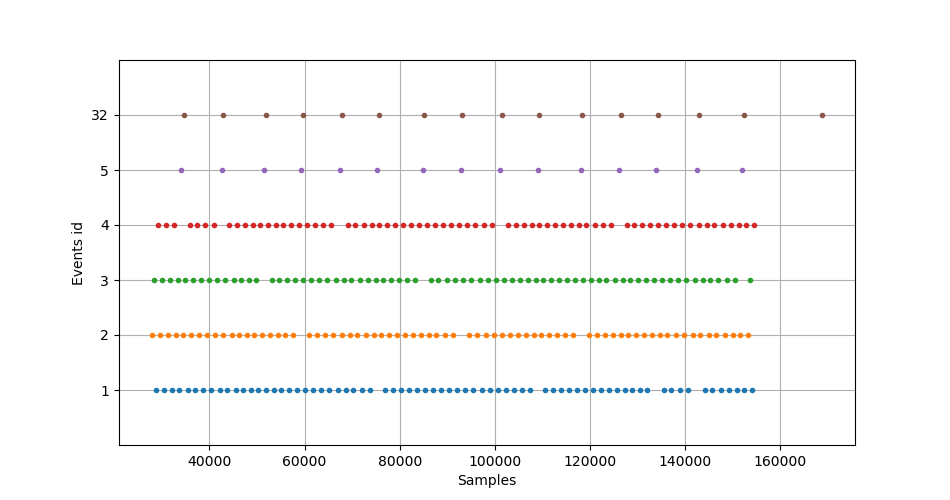

In [10]:
events = mne.find_events(raw)
mne.viz.plot_events(events);

The system generated 6 types of events. We are interested in events with ids 1 to 4, which correspond to the presentation of one of the four different type of stimuli. Lets give them names. Here is a dictionary mapping string names to event ids:

In [48]:
event_id = {
    'audio/left': 1,
    'audio/right': 2,
    'visual/left': 3,
    'visual/right': 4
}

## Creating epochs

Now that we have the information on what stimulus was presented at one time, we can extract "epochs".
Epochs are little snippets of signal surrounding an event.
These epochs can then be averaged to produce the "evoked" signal.

To cut up the continuous data into epochs, create an [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object. Pass the `raw` data, the `events` array and the `event_id` dictionary as parameters.
By default, epochs will be cut starting from 0.2 seconds *before* the onset of the event until 0.5 seconds *after* the onset.
These defaults are fine for the data we're currently analyzing.

<div style="border: 3px solid #aaccff; margin: 10px 100px; padding: 10px">
    <b>A note on creating objects in Python</b>
    
In the Python programming language, creating objects is very similar to calling functions.
To create an object of a certain class, you call the class name as a function.
For example, to create an object of type `str`, you call `str()`.
You can pass parameters like usual: `str('my string')`.
</div>

The created [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object has a `.plot()` method (like so many of MNE-Python's objects).
Try calling it to visualize the epochs. Don't forget to put a semicolon `;` at the end of your plotting call or the figure will show twice.

Write some code in the cell below to create the epochs and visualize them:

<IPython.core.display.Javascript object>


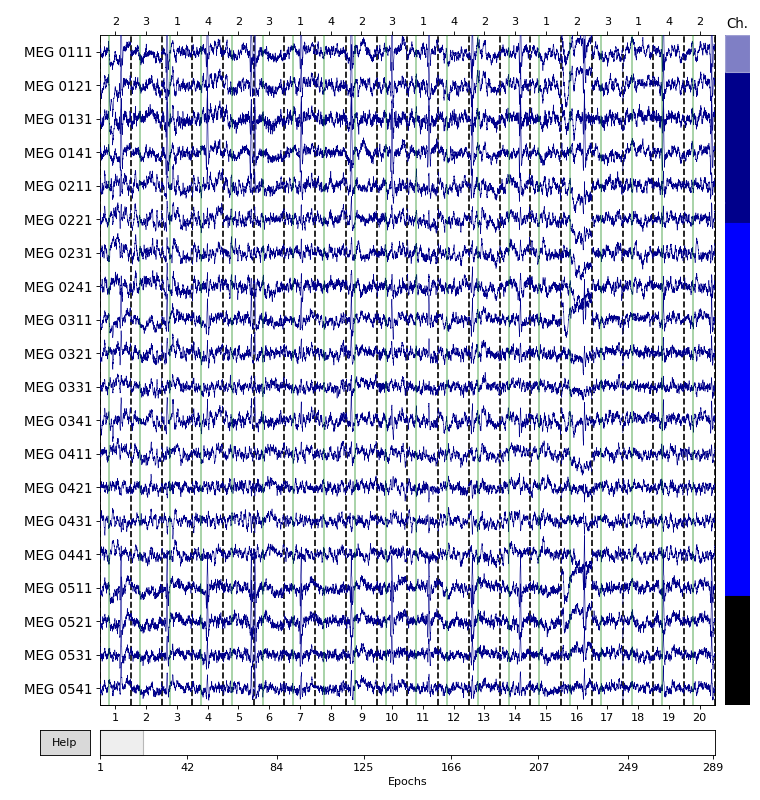

In [50]:
epochs = mne.Epochs(raw, events, stimuli, tmin=-0.2, tmax=0.5)
epochs.plot();

The figure you just created is interactive. Try clicking in the scrollbars and using the arrow keys to explore the data. Also try pressing the `b` key to switch to "butterly" mode. In this mode, all the channels are plotted on top of each other. This is a great mode for quickly checking data quality: can you spot any epochs containing anomalous spikes caused by eye-blinks and movements of the volunteer? Clicking on epochs will turn them red, causing them to be dropped from further analysis after clicking the "end interaction" button that looks like this: <img src="images/end_interaction.png" width="30" style="display: inline-block; vertical-align: middle; margin: 0px;">.

## Visualizing the evoked field

So now we have snippets of signal that are likely contain data that is related to the processing of the stimuli.
However, there are still so many overlapping signals it's difficult to see anything.

During the talks earlier today, you have heard about "evoked" data.
By averaging all the epochs corresponding to a stimulus, signals that are consistently present every time a stimulus was presented will remain, while all other signals will more or less cancel out.
The result is referred to as the "evoked" field (i.e. signals that are "evoked" by the stimulus).

Averaging epochs is simple, the [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object has a method called [`average`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs.average) for exactly that purpose.
The method doesn't need any parameters (there are some optional ones, but we can leave them alone for now) and produces a new object of type [`mne.Evoked`](https://www.martinos.org/mne/stable/generated/mne.Evoked.html).
Of course, this evoked object also has a [`plot`](https://www.martinos.org/mne/stable/generated/mne.Evoked.html#mne.Evoked.plot) method you can use to have a basic visualize it, but also a [`plot_joint`](https://www.martinos.org/mne/stable/generated/mne.Evoked.html#mne.Evoked.plot_joint) method that provides a much better visualization.

Another useful feature of the [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object is that it behaves as a Python dictionary.
To select all the epochs that correspond to a specific event type, you can index the object like so:

```python
epochs['visual/left']
```

(it uses the string descriptions that we defined in the `event_id` dictionary earlier on.)
Hence, to visualize the evoked field in response to a checkerboard presented in the left visual field of the volunteer, we write:

```python
epochs['visual/left'].average().plot_joint()
```

In the cell belows, visualize the evoked fields for all four stimuli:

<IPython.core.display.Javascript object>


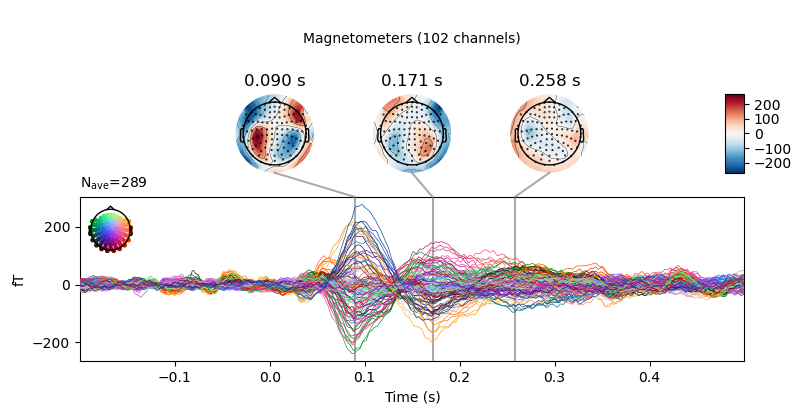

<IPython.core.display.Javascript object>


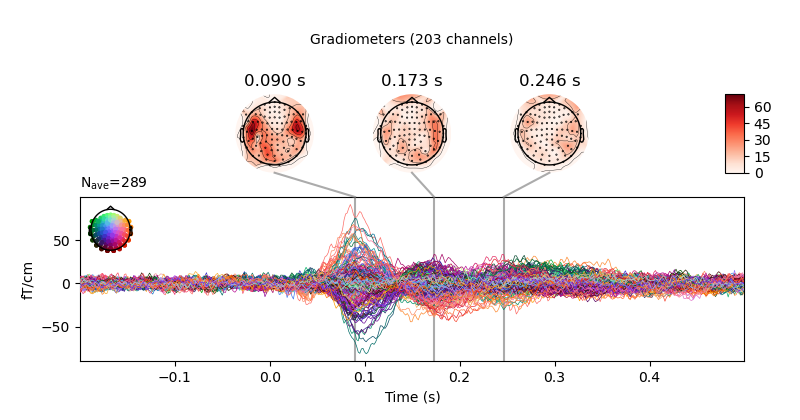

<IPython.core.display.Javascript object>


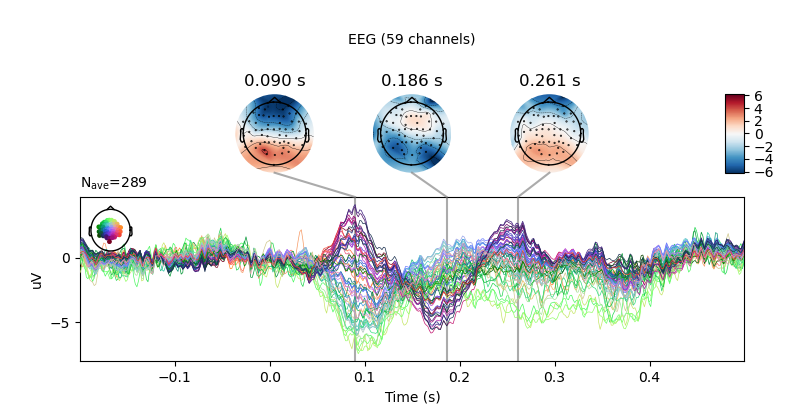

In [51]:
epochs['visual/left'].average().plot_joint();

<IPython.core.display.Javascript object>


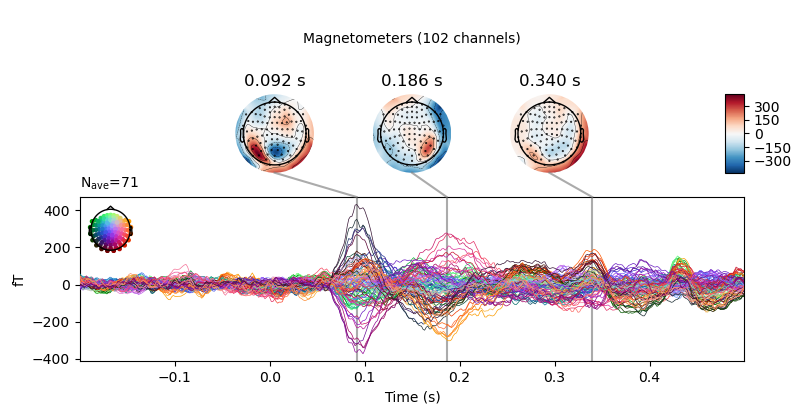

<IPython.core.display.Javascript object>


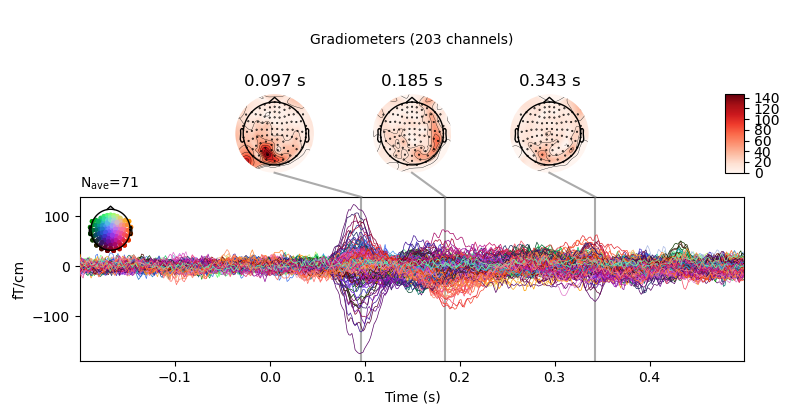

<IPython.core.display.Javascript object>


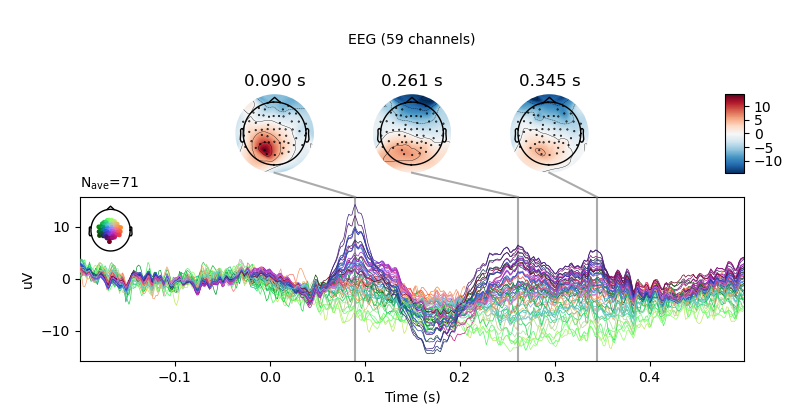

In [52]:
epochs['visual/right'].average().plot_joint();

<IPython.core.display.Javascript object>


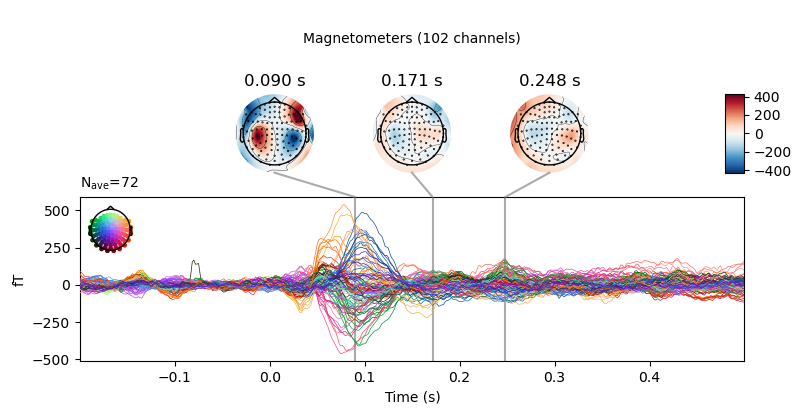

<IPython.core.display.Javascript object>


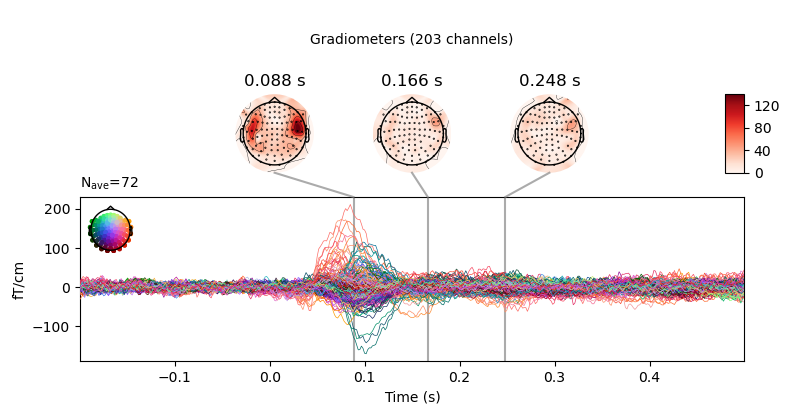

<IPython.core.display.Javascript object>


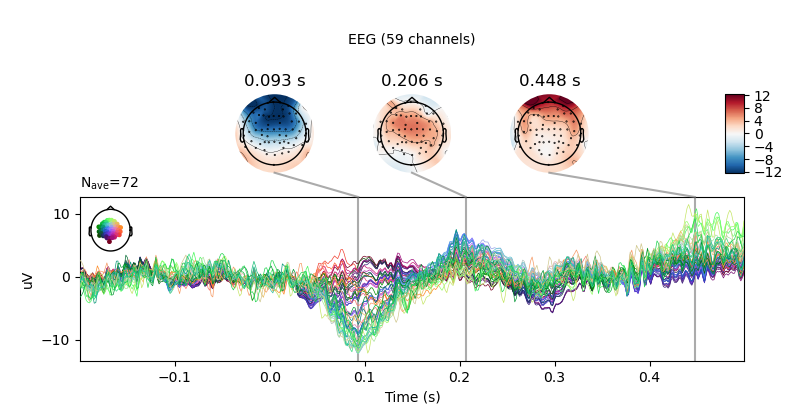

In [53]:
epochs['audio/left'].average().plot_joint();

<IPython.core.display.Javascript object>


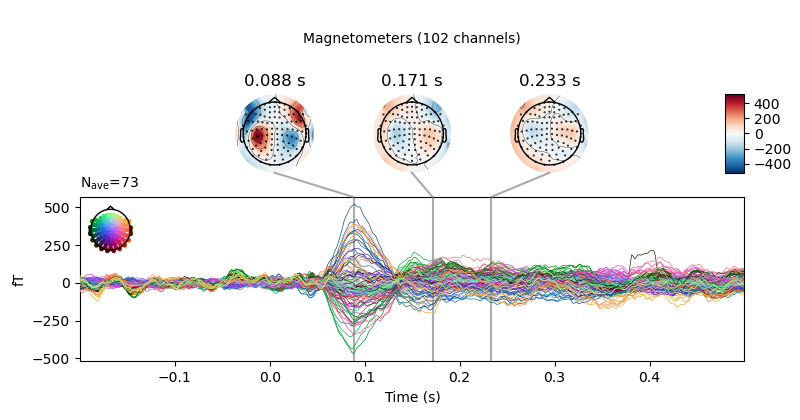

<IPython.core.display.Javascript object>


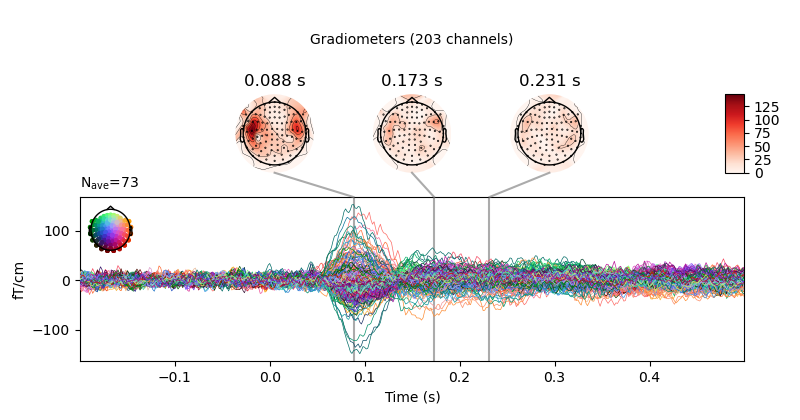

<IPython.core.display.Javascript object>


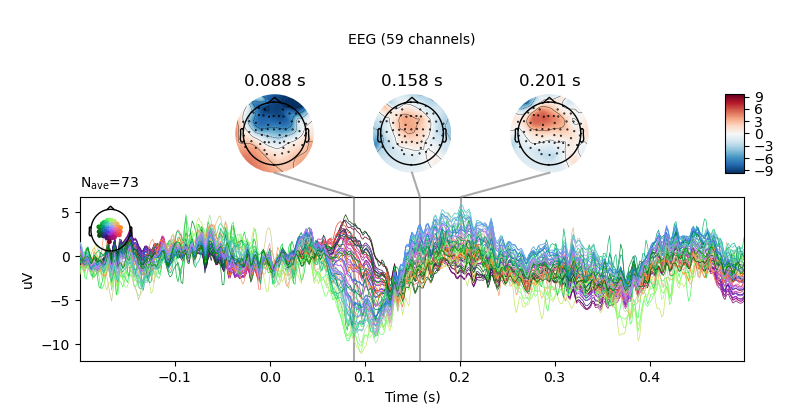

In [54]:
epochs['audio/right'].average().plot_joint();

From the evoked data, we can see several bursts of activity following the presentation of a stimulus.
You can also see how the different sensors (magnetometers, gradiometers and EEG) pick up the same signal.
Looking at the topographic maps (the "heads"), you can already see how the visual stimuli generated activity at the back of the head, where the visual cortex is located, and how auditory stimuli generated activity on the side of the head, where the auditory cortices are located.

But let's turn it up a notch and try to estimate and visualize the cortical origins of the evoked fields.

## Loading the MRI data and the concept of "subjects_dir"

As you may remember from the talks earlier today, we can use MRI data to create a detailed model of the head, which allows us to simulate the signals propagating from the cortex to the MEG and EEG sensors, which in turn allows us to estimate the cortical origins of the signal.

Processing the raw MRI data into a 3D head model takes about 24 hours and is performed by a program called [FreeSurfer](https://surfer.nmr.mgh.harvard.edu).
We don't have that kind of time right now, so I ran the program in advance for you.
FreeSurfer stores its output in a folder, which is available on this system as `data/mri`.
Inside this folder is a subfolder for each subject.
We only have one subject, called `sample`.

We are not going to load all of the FreeSurfer data into memory.
Instead, we're going to pass the MRI folder name (`'data/mri'`), and the name of our subject (`'sample'`) to the MNE-Python functions, which in turn will load the required data as needed.

Another tedious task is to align the coordinate frames of the MRI and the MEG scanners, which requires some interactive tools that unfortunately don't work in the browser.
The result of this alignment process is a coordinate transformation object, which I have also prepared for you in advance.
This transformation will be loaded into memory, which the line of code below will do for you:

In [62]:
trans = mne.read_trans('data/sample-trans.fif')

To visualize the BEM and check if the coordinate systems have been properly aligned, you can use the [`mne.viz.plot_alignment`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_alignment.html?highlight=plot_alignment) function.
Take a look at its documentation and you will see you can pass a whole list of different objects to this function.
The purpose of the function is to visualize everything you give it in the same coordinate space.
If everything lines up properly, we're good to go!

The line of code below will call the function.
Take note how the `subject` and `subjects_dir` parameters are used.
You will need to use the same parameters for any function calls that need access to the BEM.

In [65]:
mne.viz.plot_alignment(epochs.info, trans, subject='sample', subjects_dir='data/mri', surfaces=['white', 'outer_skin'])

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03 \x08\x02\x00\x00\x00T\x12\x91?\x00\…

The above figure is interactive. Drag on the figure to rotate the 3D model and check that the brain and head, which are generated from the MRI images, are aligned nicely with the MEG helmet and the EEG sensors, which locations are taken from the `epochs.info` dictionary.

In [66]:
src = mne.setup_source_space('sample', subjects_dir='data/mri', add_dist=False)
src.plot(subjects_dir='data/mri')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03 \x08\x02\x00\x00\x00T\x12\x91?\x00\…

In [67]:
bem = mne.read_bem_solution('data/mri/sample/bem/bem-sol.fif')
mne.viz.plot_bem('sample', 'data/mri');

/m/home/home4/45/vanvlm1/data/projects/mne-python/mne/viz/utils.py:457: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  1.5 * nrow + 1))


<IPython.core.display.Javascript object>

In [68]:
fwd = mne.make_forward_solution(epochs.info, trans, src, bem)

<ipython-input-69-486c0bc5a424>:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0, method='shrunk')
/m/home/home4/45/vanvlm1/data/projects/mne-python/mne/viz/misc.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figsize=(3.8 * len(idx_names), 3.7))


<IPython.core.display.Javascript object>


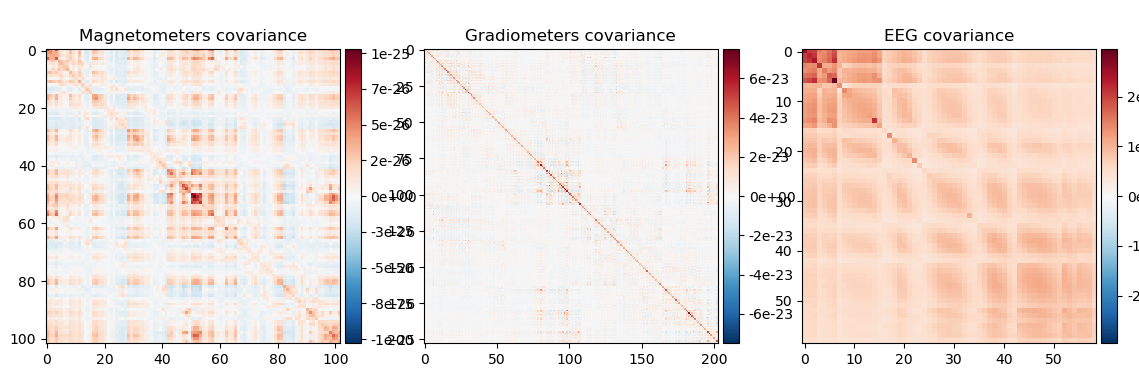

/m/home/home4/45/vanvlm1/data/projects/mne-python/mne/viz/misc.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figsize=(3.8 * len(idx_names), 3.7))


<IPython.core.display.Javascript object>


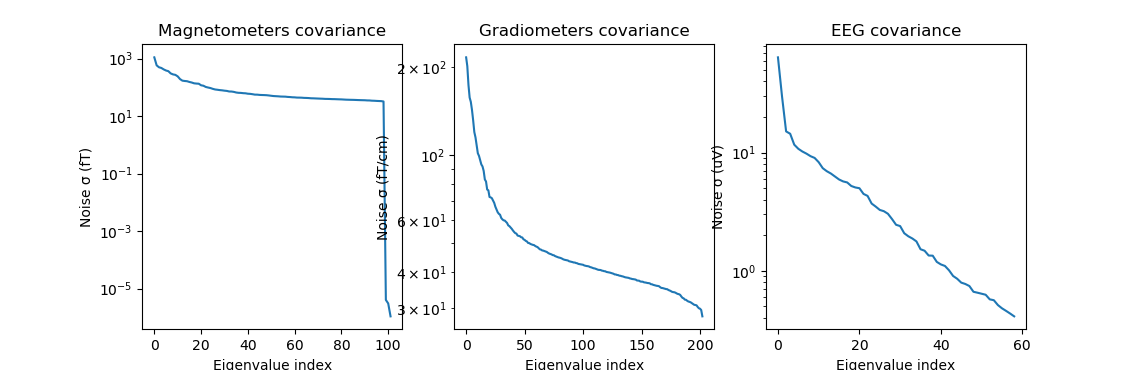

In [69]:
noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0, method='shrunk')
mne.viz.plot_cov(noise_cov, epochs.info);

In [70]:
from mne.minimum_norm import make_inverse_operator
inv = make_inverse_operator(epochs.info, fwd, noise_cov)

<ipython-input-70-e93ac66acad2>:2: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inv = make_inverse_operator(epochs.info, fwd, noise_cov)
<ipython-input-70-e93ac66acad2>:2: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inv = make_inverse_operator(epochs.info, fwd, noise_cov)


In [71]:
from mne.minimum_norm import apply_inverse

# Apply inverse solution
snr = 3.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(evoked['vl'], inv, lambda2, 'dSPM')

# Plot the source estimate
stc.plot(initial_time=0.1, hemi='both', size=400,
         subjects_dir='data/mri',
         views=['caudal'])

NameError: name 'evoked' is not defined